In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
from sklearn.model_selection import train_test_split
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes
from sklearn.utils import shuffle

from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import  execute, BasicAer

In [2]:
name="_smear0.1_MaxTran10_shuffle0"

folderDir="/Users/lizhelun/Desktop/QC/VQC-Permutable-Lorentz-symmetry/"
dataDir="/Users/lizhelun/Desktop/QC/VQC-Permutable-Lorentz-symmetry/Images"
resultsName="results"

#nShots=2**13
maxIteration=1000
maxEvents=500
nLayer=3

training_results={}



with open(dataDir+"/label"+name+".pk", "rb") as fp:   #Pickling
    label=pickle.load(fp)
    
with open(dataDir+"/images"+name+".pk", "rb") as fp:   #Pickling
    images=pickle.load(fp)
    
X=images.reshape(images.shape[0],images.shape[1]*images.shape[2])
y=label

X,y=shuffle(X,y,random_state=1000)
train_ratio=0.6
X_train, X_valTest, y_train, y_valTest = train_test_split(X.copy(), y.copy(), train_size=train_ratio, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_valTest, y_valTest, test_size=0.5, random_state=200)
#Normalizing everythings:
X_train=X_train/X_train.max()
X_val=X_val/X_val.max()
X_test=X_test/X_test.max()



sampler = Sampler()

In [3]:
# with open(dataDir+"/outputDict"+name+".pk", "rb") as fp:   #Pickling
#     Dict=pickle.load(fp)
# dictTrain={"0":[], "1":[],"7":[]}
# dictTest={"0":[], "1":[],"7":[]}


# for key in Dict.keys():
#     Dict_reshape=Dict[key].reshape(Dict[key].shape[0],images.shape[1]*images.shape[2])


#     Dict_reshape=shuffle(Dict_reshape,random_state=1000)
#     train_ratio=0.6
    
#     Dict_reshape_train=X[0:int(Dict_reshape.shape[0]*train_ratio)]
#     Dict_reshape_test=X[int(Dict_reshape.shape[0]*train_ratio):]
#     #Normalizing everythings:
#     Dict_reshape_train=Dict_reshape_train/Dict_reshape_train.max()
#     Dict_reshape_test=Dict_reshape_test/Dict_reshape_test.max()
    
#     dictTrain[key]=Dict_reshape_train
#     dictTest[key]=Dict_reshape_train

In [4]:
def dataAugmentation(data):
    #centering
    meanValues=data.mean(axis=1)
    print(data.shape)
    print(meanValues.shape)
    data=data-meanValues[:,None,:]
    
    #scaling
    norm=np.linalg.norm(data,axis=2)
    scale=norm.max(axis=1)
    data=data/scale[:,None,None]
    
    return data

def Dot(data):
    output=[]
    for i in range(data.shape[0]):
        event=[]
        for j in range(data.shape[1]):
            for k in np.arange(j,data.shape[1]):
                event.append((data[i][j]*data[i][k]).sum())
        output.append(np.array(event))

    
    output=np.array(output)
    return output
    

In [5]:



objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [6]:

num_qubits=X.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
optimizer = COBYLA(maxiter=maxIteration)




In [7]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=RealAmplitudes(num_qubits, reps=nLayer),
    optimizer=optimizer,
    callback=callback_graph,
)

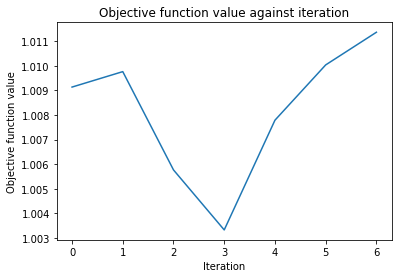

In [ ]:


# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train[0:maxEvents], y_train[0:maxEvents])
elapsed = time.time() - start

In [ ]:
vqc.score(X_train[0:maxEvents],y_train[0:maxEvents])

In [ ]:
vqc.score(X_val[0:maxEvents],y_val[0:maxEvents])

In [ ]:
vqc.score(X_val[0:maxEvents],y_train[0:maxEvents])

In [ ]:
diff=vqc.predict(X_val[0:maxEvents])-y_train[0:maxEvents]

print(np.sum(diff**2)/maxEvents)

In [ ]:
training_results["baseline"]=np.array(objective_func_vals)

In [ ]:
training_results["baseline_val"]=np.array(vqc.score(X_val[0:maxEvents],y_val[0:maxEvents]))

In [ ]:
X_centerScale=dataAugmentation(images).reshape(images.shape[0],images.shape[1]*images.shape[2])
y_centerScale=label

X_centerScale,y_centerScale=shuffle(X_centerScale,y_centerScale,random_state=1000)
train_ratio=0.6
X_train_centerScale, X_valTest_centerScale, y_train_centerScale, y_valTest_centerScale = train_test_split(X_centerScale.copy(), y_centerScale.copy(), train_size=train_ratio, random_state=100)
X_val_centerScale, X_test_centerScale, y_val_centerScale, y_test_centerScale = train_test_split(X_valTest_centerScale, y_valTest_centerScale, test_size=0.5, random_state=200)
#Normalizing everythings:
X_train_centerScale=X_train_centerScale/X_train_centerScale.max()
X_val_centerScale=X_val_centerScale/X_val_centerScale.max()
X_test_centerScale=X_test_centerScale/X_test_centerScale.max()


In [ ]:



feature_map_centerScale = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
optimizer_centerScale = COBYLA(maxiter=maxIteration)

vqc_centerScale = VQC(
    sampler=sampler,
    feature_map=feature_map_centerScale,
    ansatz=RealAmplitudes(num_qubits, reps=nLayer),
    optimizer=optimizer_centerScale,
    callback=callback_graph,
)

In [ ]:


# clear objective value history
objective_func_vals = []

start = time.time()
vqc_centerScale.fit(X_train_centerScale[0:maxEvents], y_train_centerScale[0:maxEvents])
elapsed = time.time() - start

In [ ]:
vqc_centerScale.score(X_val_centerScale[0:maxEvents],y_val_centerScale[0:maxEvents])

In [ ]:
vqc_centerScale.score(X_val_centerScale[0:maxEvents],y_train_centerScale[0:maxEvents])

In [ ]:
diff=vqc_centerScale.predict(X_val_centerScale[0:maxEvents])-y_train_centerScale[0:maxEvents]
#print(len(np.where(np.sum(diff**2,axis=1)==0)[0])/maxEvents)
print(np.sum(diff**2)/maxEvents)

In [ ]:
training_results["centerScale"]=np.array(objective_func_vals)

In [ ]:
training_results["centerScale_val"]=np.array(vqc_centerScale.score(X_val_centerScale[0:maxEvents],y_train_centerScale[0:maxEvents]))

In [ ]:

X_augDot=Dot(dataAugmentation(images))
y_augDot=label

X_augDot,y_augDot=shuffle(X_augDot,y_augDot,random_state=1000)
train_ratio=0.6
X_train_augDot, X_valTest_augDot, y_train_augDot, y_valTest_augDot = train_test_split(X_augDot.copy(), y_augDot.copy(), train_size=train_ratio, random_state=100)
X_val_augDot, X_test_augDot, y_val_augDot, y_test_augDot = train_test_split(X_valTest_augDot, y_valTest_augDot, test_size=0.5, random_state=200)
#Normalizing everythings:
X_train_augDot=X_train_augDot/X_train_augDot.max()
X_val_augDot=X_val_augDot/X_val_augDot.max()
X_test_augDot=X_test_augDot/X_test_augDot.max()

In [ ]:
num_qubits=X_augDot.shape[1]



sampler = Sampler()

feature_map_augDot = ZZFeatureMap(feature_dimension=num_qubits, reps=1)
optimizer_augDot = COBYLA(maxiter=maxIteration)


vqc_augDot = VQC(
    sampler=sampler,
    feature_map=feature_map_augDot,
    ansatz=RealAmplitudes(num_qubits, reps=nLayer),
    optimizer=optimizer_augDot,
    callback=callback_graph,
)

In [ ]:


# clear objective value history
objective_func_vals = []

start = time.time()
vqc_augDot.fit(X_train_augDot[0:maxEvents], y_train_augDot[0:maxEvents])
elapsed = time.time() - start

In [ ]:
vqc_augDot.score(X_train_augDot[0:maxEvents],y_train_augDot[0:maxEvents])

In [ ]:
vqc_augDot.score(X_val_augDot[0:maxEvents],y_val_augDot[0:maxEvents])

In [ ]:
vqc_augDot.score(X_val_augDot[0:maxEvents],y_train_augDot[0:maxEvents])

In [ ]:
training_results["centerScale+Dot_val"]=np.array(vqc_augDot.score(X_val_augDot[0:maxEvents],y_val_augDot[0:maxEvents]))

In [ ]:
diff=vqc_augDot.predict(X_val_augDot[0:maxEvents])-y_val_augDot[0:maxEvents]
#print(len(np.where(np.sum(diff**2,axis=1)==0)[0])/maxEvents)
print(np.sum(diff**2)/maxEvents)

In [ ]:
training_results["centerScale+Dot"]=np.array(objective_func_vals)

In [ ]:
training_results.keys()

In [ ]:
LabelSize=30
plt.figure(1)
plt.figure(figsize=(16,9))
plt.xlabel("Iteration", fontsize = LabelSize)
plt.ylabel("Loss", fontsize = LabelSize)
for key in ["baseline","centerScale","centerScale+Dot"]:
    plt.plot(range(len(training_results[key])), training_results[key ],label=key )
    
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=30)
plt.show()
#plt.savefig(folderDir+"/training.png")

In [ ]:

with open(folderDir+"/results/"+resultsName+".pk", "wb") as fp:   #Pickling
    pickle.dump(training_results, fp)

In [ ]:
with open(folderDir+"/results/"+resultsName+".pk", "rb") as fp:   #Pickling
    training_results=pickle.load(fp)

In [ ]:
training_results